In [2]:
# Imports
import numpy as np

from pandas import read_csv 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score

import matplotlib.pyplot as plt

In [3]:
#  Load dataset and create train-test sets
data = read_csv('data/hairdryer.csv')

In [4]:
var_names = data.columns[0:-1]

<Axes: >

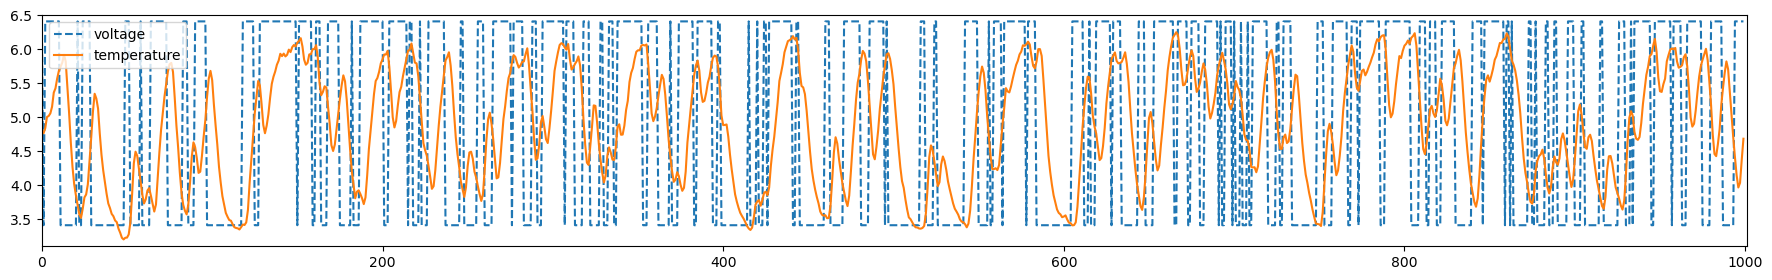

In [5]:
data.plot(figsize=(22,3) , xlim=(0,1001) , ylim=(3.1 , 6.5) , style=['--','-'])

<Axes: >

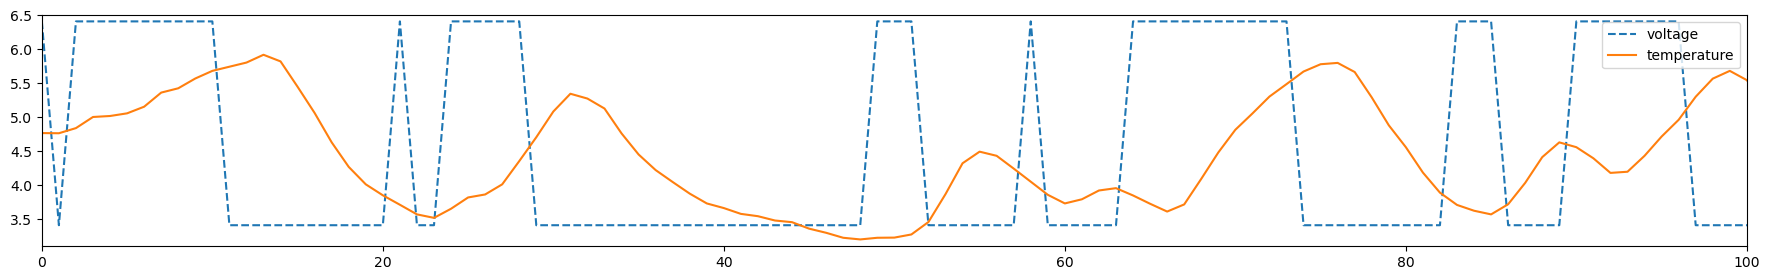

In [6]:
data.plot(figsize=(22,3) , xlim=(0,100) , ylim=(3.1 , 6.5) , style=['--','-'])

In [7]:
data = data.to_numpy()

(3.1, 6.5)

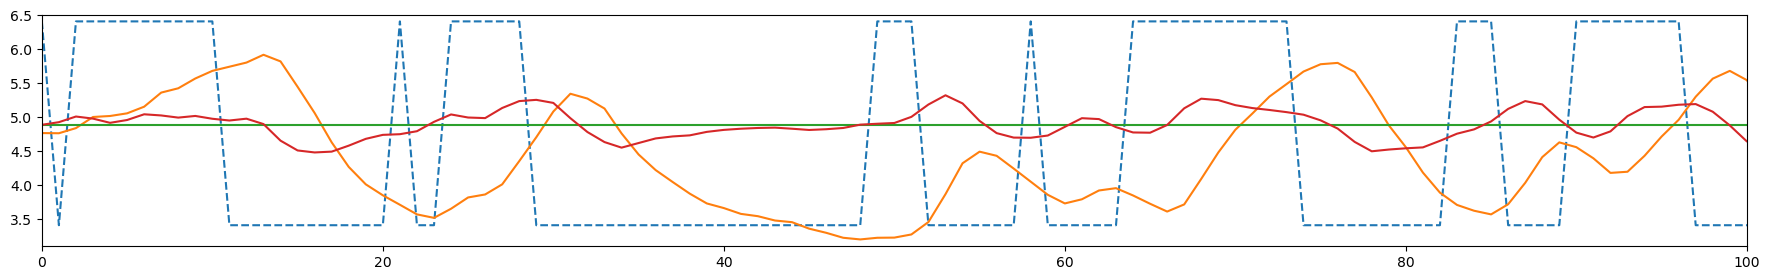

In [8]:
x_grad= np.arange(data[:,1].size)
temp_mean=np.mean(data[:,1])

plt.figure(figsize=(22, 3))  # Set figure size

plt.plot( x_grad ,data[:,0] , '--')
plt.plot( x_grad ,data[:,1] ,'-')
plt.plot( [0,1000], [temp_mean,temp_mean])
plt.plot( x_grad, np.gradient(data[:,1], x_grad)+temp_mean)

plt.xlim(0,100) 
plt.ylim(3.1 , 6.5)


In [9]:
%%script echo skipping

# Run this cell to normalize variables
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

Couldn't find program: 'echo'


In [10]:
# train/test split
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

In [11]:
# %% Cluster the input-output space

number_of_clusters = 5

cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=number_of_clusters)  # Number of clusters
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

In [12]:
# %% Estimate membership functions parameters
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

In [13]:
# %% Estimate consequent parameters
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [14]:
# %% Build first-order Takagi-Sugeno model
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=True) #change this setting to save simpful code
model = modbuilder.get_model()

 * Detected 5 rules / clusters
 * Code saved to file Simpful_code.py
 * Detected Sugeno model type


In [15]:
# %% Get model predictions
modtester = SugenoFISTester(model, X_test, var_names)
y_pred = modtester.predict()[0]

In [16]:
# %% Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.3f}".format(mse))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error: {:.1f}%".format(mape*100))
exp_var = explained_variance_score(y_test, y_pred)
print("Explained Variance Score: {:.3f}".format(exp_var))

Mean Squared Error: 0.686
Mean Absolute Percentage Error: 15.5%
Explained Variance Score: 0.014


# Comparing settings

Fazer gráfico train error vs test error 

 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 2
Training MSE: 1.215, Test MSE: 1.275
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 3
Training MSE: 1.512, Test MSE: 1.562
 * Detected 4 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 4
Training MSE: 0.847, Test MSE: 0.897
 * Detected 5 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 5
Training MSE: 0.717, Test MSE: 0.761
 * Detected 6 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 6
Training MSE: 0.680, Test MSE: 0.725
 * Detected 7 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 7
Training MSE: 0.684, Test MSE: 0.717
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: gk, Clusters: 2
Training MSE: 3897092503554.192, Test MSE: 3760231600782.481
 * Detected 3 rules / clusters
 * Detected Sugeno model type

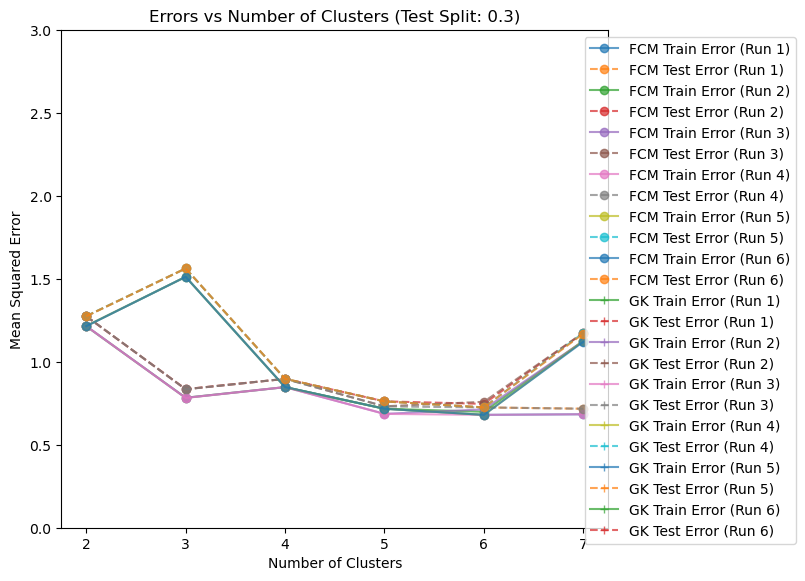

 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 2
Training MSE: 1.108, Test MSE: 1.187
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 3
Training MSE: 1.474, Test MSE: 1.572
 * Detected 4 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 4
Training MSE: 1.127, Test MSE: 1.094
 * Detected 5 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 5
Training MSE: 0.733, Test MSE: 0.731
 * Detected 6 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 6
Training MSE: 0.748, Test MSE: 0.747
 * Detected 7 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 7
Training MSE: 0.865, Test MSE: 0.833
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: gk, Clusters: 2
Training MSE: 4844993718884480581632.000, Test MSE: 5029717214302357684224.000
 * Detected 3 rules / clusters
 * Detected

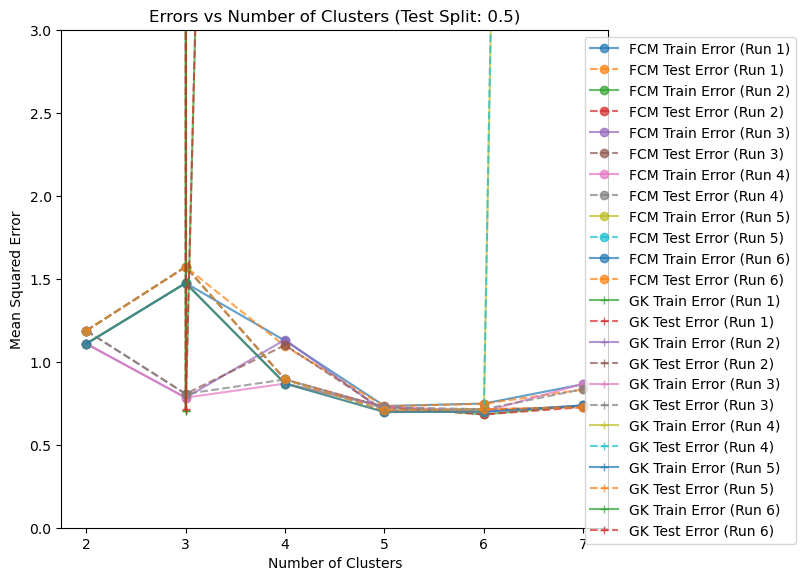

 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 2
Training MSE: 1.440, Test MSE: 1.421
 * Detected 3 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 3
Training MSE: 1.546, Test MSE: 1.536
 * Detected 4 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 4
Training MSE: 0.913, Test MSE: 0.911
 * Detected 5 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 5
Training MSE: 0.744, Test MSE: 0.761
 * Detected 6 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 6
Training MSE: 0.734, Test MSE: 0.718
 * Detected 7 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: fcm, Clusters: 7
Training MSE: 0.716, Test MSE: 0.698
 * Detected 2 rules / clusters
 * Detected Sugeno model type
Run: 1, Method: gk, Clusters: 2
Training MSE: 69784619852317665001472.000, Test MSE: 69784619852317765664768.000
 * Detected 3 rules / clusters
 * Detect

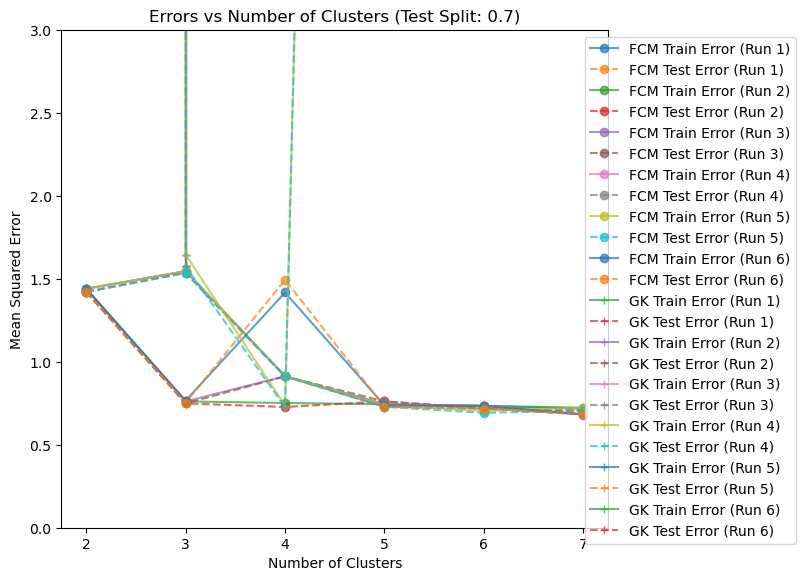

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the test split sizes and the number of runs
test_split_sizes = [0.3, 0.5, 0.7]
n_runs = 6  # Number of times to fit the model for each test split size

# Loop over different test split sizes
for split_size in test_split_sizes:
    # Initialize lists to store errors from multiple runs
    all_fcm_train_errors = []
    all_fcm_test_errors = []
    all_gk_train_errors = []
    all_gk_test_errors = []

    # Perform multiple runs for the same test split size
    for run in range(n_runs):
        # Train/test split
        X = data[:, 0:-1]
        y = data[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=314)  # Different random seed per run

        # Lists to store errors for each method in this run
        fcm_train_errors = []
        fcm_test_errors = []
        gk_train_errors = []
        gk_test_errors = []

        ncl = np.arange(2, 8)
        mtd = ['fcm', 'gk']
        
        # Capture training and test errors
        for mth in mtd:
            train_errors = []
            test_errors = []
            
            for n in ncl:
                # Clustering
                cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=n)
                clust_centers, part_matrix, _ = cl.cluster(method=mth)

                # Estimate membership functions parameters
                ae = AntecedentEstimator(X_train, part_matrix)
                antecedent_params = ae.determineMF()

                # Estimate consequent parameters
                ce = ConsequentEstimator(X_train, y_train, part_matrix)
                conseq_params = ce.suglms(global_fit=True)  # Using global_fit as an example

                # Build the first-order Takagi-Sugeno model
                modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
                model = modbuilder.get_model()

                # Predictions on training data
                modtester_train = SugenoFISTester(model, X_train, var_names)
                y_train_pred = modtester_train.predict()[0]
                
                # Predictions on test data
                modtester_test = SugenoFISTester(model, X_test, var_names)
                y_test_pred = modtester_test.predict()[0]

                # Compute training and test errors
                train_mse = mean_squared_error(y_train, y_train_pred)
                test_mse = mean_squared_error(y_test, y_test_pred)

                # Store errors for the current method and cluster count
                train_errors.append(train_mse)
                test_errors.append(test_mse)

                print(f"Run: {run + 1}, Method: {mth}, Clusters: {n}")
                print(f"Training MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}")
            
            # Store the results for each method separately for this run
            if mth == 'fcm':
                fcm_train_errors = train_errors
                fcm_test_errors = test_errors
            elif mth == 'gk':
                gk_train_errors = train_errors
                gk_test_errors = test_errors
        
        # Append errors from this run to the overall lists
        all_fcm_train_errors.append(fcm_train_errors)
        all_fcm_test_errors.append(fcm_test_errors)
        all_gk_train_errors.append(gk_train_errors)
        all_gk_test_errors.append(gk_test_errors)

    # Plotting the errors vs number of clusters for the current test split
    plt.figure(figsize=(10, 6))

    # Plot errors for each run for FCM method
    for run in range(n_runs):
        plt.plot(ncl, all_fcm_train_errors[run], 'o-', label=f'FCM Train Error (Run {run + 1})', alpha=0.7)
        plt.plot(ncl, all_fcm_test_errors[run], 'o--', label=f'FCM Test Error (Run {run + 1})', alpha=0.7)

    # Plot errors for each run for GK method
    for run in range(n_runs):
        plt.plot(ncl, all_gk_train_errors[run], '+-', label=f'GK Train Error (Run {run + 1})', alpha=0.7)
        plt.plot(ncl, all_gk_test_errors[run], '+--', label=f'GK Test Error (Run {run + 1})', alpha=0.7)

    # Title and axis labels
    plt.title(f'Errors vs Number of Clusters (Test Split: {split_size})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Mean Squared Error')

    # Set y-limits for better visualization
    plt.ylim(0, 3)

    # Show legend outside the plot area
    plt.legend(loc='upper center', bbox_to_anchor=(1.15, 1), ncol=1)  # Legend placed outside

    # Show plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit legend

    # Show plot
    plt.show()


fazer gráfico com actual vs predicted values

In [18]:
%%script echo skipping

### Plot the actual values vs the predicted values of the test data using the matplotlib library

# this is done already on the cell above 
""""# Predict the labels of the test data
pred = model.predict_test_data()"""


"""# Get the actual labels of the test data
_, actual = modbuilder.get_data(data_set='test')
"""

# Create scatterplot
import matplotlib.pyplot as plt 
plt.scatter(y_test, y_pred)
plt.xlabel('Actual value') 
plt.ylabel('Predicted value')
#plt.plot([0,85],[0,85],'r')     # Add a reference line
plt.show()

Couldn't find program: 'echo'


usar K-fold CV para obter performance de cada modelo (modelos com diferentes numeros de clusters)